<a href="https://colab.research.google.com/github/rayheberer/fraud_logistic_regression/blob/master/Fraud_Detection_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

sns.set()

## Import Data

I am working in a Google Colab environment. In order to import the data through the kaggle CLI, one must ensure that a kaggle API file (kaggle.json) is located somewhere in their Google Drive.

For training the model, I will only use the transaction data. This is because logistic regression models cannot handle missing data natively, and there is high missingness in the identity data, that is probably not worth joining to the transaction data and imputing.

In [2]:
# Import kaggle.json from google drive
# This snippet will output a link which needs authentication from any google account
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
    q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
# print(kaggle_api_key)
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
! kaggle competitions download -c ieee-fraud-detection

 78% 41.0M/52.5M [00:00<00:00, 81.3MB/s]
100% 52.5M/52.5M [00:00<00:00, 132MB/s] 
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 98.4MB/s]
 95% 45.0M/47.3M [00:00<00:00, 129MB/s]
100% 47.3M/47.3M [00:00<00:00, 136MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 97.7MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 76.3MB/s]


In [4]:
train_transaction = pd.read_csv("train_transaction.csv.zip")

train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualize Data

There are a ton of columns, so let's examine the distributions of a few of the ones that have a human-understandable name.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


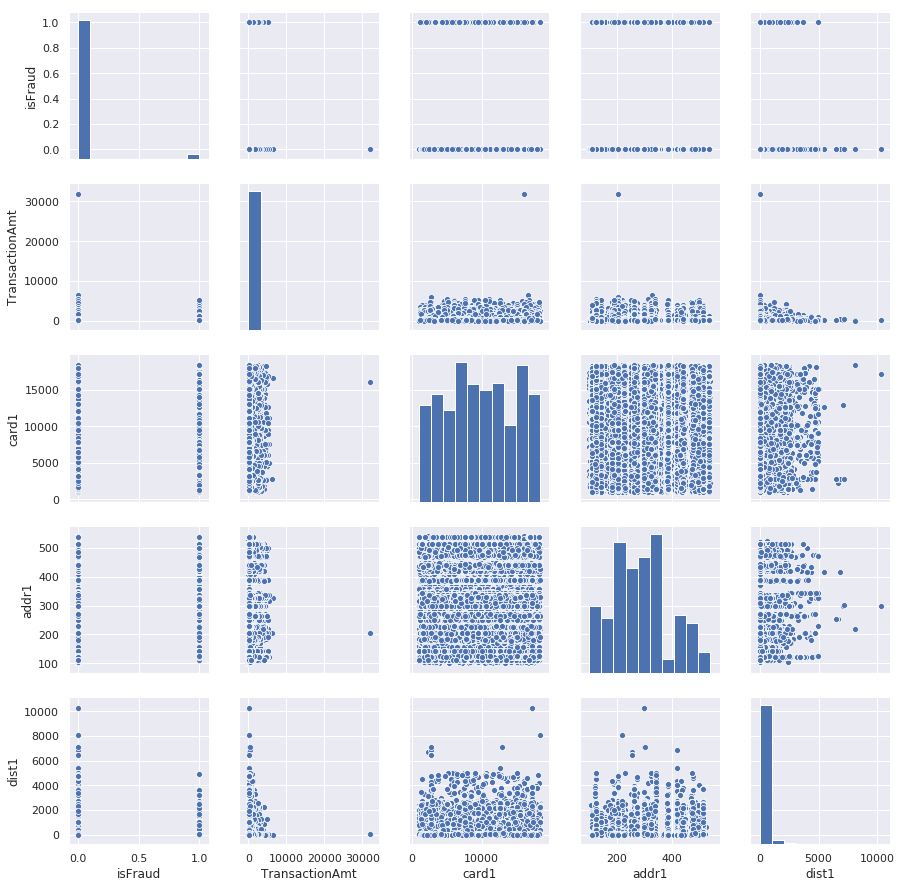

In [5]:
sns.pairplot(train_transaction[["isFraud", "TransactionAmt", "card1", "addr1", "dist1"]]);

## Preprocess Data

Nothing too fancy; I'll drop columns with over 20% missing values, median impute the remaining numeric columns, mode-impute the categoricals, then one-hot encode them. Logistic regression isn't too sensitive to scale, so I won't rescale the data.

In [6]:
# drop columns with over 20% NaNs

df_dropped = train_transaction.dropna(thresh=4 * train_transaction.shape[0]//5, axis=1)
print(train_transaction.shape)
print(df_dropped.shape)

(590540, 394)
(590540, 182)


In [7]:
# median imputation
df_imputed = df_dropped.fillna(value=df_dropped.median())
print(df_dropped.isnull().sum().sum())
print(df_imputed.isnull().sum().sum())

5667093
97604


In [8]:
# filling categorical NaNs with mode
df_cat_imputed = df_imputed.fillna(value=df_imputed.mode().iloc[0])
print(df_cat_imputed.isnull().sum().sum())

0


In [9]:
# one-hot encoding categoricals
df_preprocessed = pd.get_dummies(df_cat_imputed)
print(df_cat_imputed.shape)
print(df_preprocessed.shape)

(590540, 182)
(590540, 250)


In [10]:
X_train = df_preprocessed.drop("isFraud", axis=1)
y_train = df_preprocessed["isFraud"]
display(X_train.head())
display(y_train.head())

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,...,P_emaildomain_hotmail.com,P_emaildomain_hotmail.de,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_mac.com,P_emaildomain_mail.com,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_netzero.com,P_emaildomain_netzero.net,P_emaildomain_optonline.net,P_emaildomain_outlook.com,P_emaildomain_outlook.es,P_emaildomain_prodigy.net.mx,P_emaildomain_protonmail.com,P_emaildomain_ptd.net,P_emaildomain_q.com,P_emaildomain_roadrunner.com,P_emaildomain_rocketmail.com,P_emaildomain_sbcglobal.net,P_emaildomain_sc.rr.com,P_emaildomain_servicios-ta.com,P_emaildomain_suddenlink.net,P_emaildomain_twc.com,P_emaildomain_verizon.net,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
0,2987000,86400,68.5,13926,361.0,150.0,142.0,315.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,13.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2987001,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2987002,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,315.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2987003,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,84.0,111.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2987004,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,15.0,52.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


0    0
1    0
2    0
3    0
4    0
Name: isFraud, dtype: int64

## Train Model

In [11]:
model = LogisticRegression(solver="sag")

model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
model.score(X_train, y_train)

0.9650099908558268

The score looks good, but keep in mind that the data has high class-imbalance. Fraud is very rare to begin with. It wouldn't be surprising if a linear model only managed to learn to predict non fraud for just about everything.

In [15]:
1 - y_train.mean()

0.9650099908558268

In [18]:
np.sum(model.predict(X_train))

0

So, we've learned that a logistic regression model is a poor choice to handle highly imbalanced data. That is a good lesson, and doesn't take away from the fact that through this exercise, we've gotten comfortable with a minimal machine learning workflow. The eventual goal is to be able to embed this workflow within a larger framework of an app or service, so it's okay that it is very basic.